# Intersection Congestion
### Can you predict wait times at major city intersections?

![Banner](https://raw.githubusercontent.com/xalemsharan/intersection_congestion/master/Banner.jpg)

We’ve all been there: Stuck at a traffic light, only to be given mere seconds to pass through an intersection, behind a parade of other commuters. Imagine if you could help city planners and governments anticipate traffic hot spots ahead of time and reduce the stop-and-go stress of millions of commuters like you.

Geotab provides a wide variety of aggregate datasets gathered from commercial vehicle telematics devices. Harnessing the insights from this data has the power to improve safety, optimize operations, and identify opportunities for infrastructure challenges.

The dataset includes aggregate stopped vehicle information and intersection wait times. Let's try to understand the factors affecting congestion at intersections and predict congestion, based on an aggregate measure of stopping distance and waiting times, at intersections in 4 major US cities: Atlanta, Boston, Chicago & Philadelphia.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# dataframe display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# setting style for plotting
sns.set_style('darkgrid')
plt.style.use('ggplot')

C:\DataScience\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Reading and understanding data

In [3]:
# reading data from csv and creating dataframe
df = pd.read_csv("C:/Users/shara/Desktop/Projects/GeoTab-IntersectionAnalysis/intersection_congestion.csv")

# dataframe dimensions
print(f"This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")

This dataframe has 856387 rows and 28 columns.


In [4]:
# dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856387 entries, 0 to 856386
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RowId                    856387 non-null  int64  
 1   IntersectionId           856387 non-null  int64  
 2   Latitude                 856387 non-null  float64
 3   Longitude                856387 non-null  float64
 4   EntryStreetName          848239 non-null  object 
 5   ExitStreetName           850100 non-null  object 
 6   EntryHeading             856387 non-null  object 
 7   ExitHeading              856387 non-null  object 
 8   Hour                     856387 non-null  int64  
 9   Weekend                  856387 non-null  int64  
 10  Month                    856387 non-null  int64  
 11  Path                     856387 non-null  object 
 12  TotalTimeStopped_p20     856387 non-null  float64
 13  TotalTimeStopped_p40     856387 non-null  float64
 14  Tota

### Variable Information

| **Variable** | **Description** |
|:--- | --- |
|**RowId** | Identity variable to identify each row (datapoint)|
|**IntersectionId** | A unique identifier assigned to each intersection|
|**Latitude** | Latitude of the intersection|
|**Longitude** | Longitude of the intersection|
|**EntryStreetName** | Name of the street from which the vehicle is entering an intersection|
|**ExitStreetName** | Name of the street to which the vehicle is exiting an intersection|
|**EntryHeading** | Geographic direction from which the vehicle is entering an intersection|
|**ExitHeading** | Geographic direction in which the vehicle is exiting an intersection|
|**Hour** | Hour of the day (24Hr) as a 2-digit string|
|**Weekend** | Weekend (1) or weekday (0)|
|**Month** | Numeric value of the month (12 month) as a string|
|**Path** | Path of the vehicle as a combination of entry and exit bearing. (Format: StartStreet_EntryHeading_EndStreet_ExitHeading)|
|**TotalTimeStopped** | Total time (in sec) spent stopped (idling) while waiting to pass through an intersection. Values at 20th, 40th, 50th, 60th, 80th percentiles.|
|**TimeFromFirstStop** | Time (in sec) to pass through the intersection measured from the first stop after exiting the previous intersection. Values at 20th, 40th, 50th, 60th, 80th percentiles.|
|**DistanceFromFirstStop** | Distance (in meter) from the first stop to the final point before passing through the intersection. Values at 20th, 40th, 50th, 60th, 80th percentiles.|

In [5]:
# sample rows
df.sample(5)

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
412939,2334296,1695,41.666186,-87.558874,South Torrence Avenue,South Torrence Avenue,S,S,9,0,6,South Torrence Avenue_S_South Torrence Avenue_S,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,0.0,0.0,73.4,Chicago
216637,2137994,377,42.301908,-71.085663,Blue Hill Avenue,Blue Hill Avenue,N,N,21,0,12,Blue Hill Avenue_N_Blue Hill Avenue_N,0.0,0.0,0.0,9.0,24.0,0.0,0.0,0.0,22.0,33.0,0.0,0.0,0.0,65.5,80.4,Boston
259570,2180927,683,42.365758,-71.060689,Causeway Street,Causeway Street,NE,NE,18,0,10,Causeway Street_NE_Causeway Street_NE,0.0,20.0,48.0,58.0,92.0,0.0,39.0,57.0,74.0,99.0,0.0,65.4,74.0,93.8,124.4,Boston
70200,1991557,211,33.653093,-84.367535,Jonesboro Road Southeast,Jonesboro Road Southeast,NW,NW,16,0,7,Jonesboro Road Southeast_NW_Jonesboro Road Sou...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
453222,2374579,2580,41.808923,-87.643115,West 47th Street,West 47th Street,W,W,11,0,7,West 47th Street_W_West 47th Street_W,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,65.0,Chicago


# Data quality

## Missing values

In [6]:
# percentage of missing values
pd.DataFrame(zip(df.isna().any(),
                 round(df.isna().sum() / df.shape[0] * 100, 2)),
            index = df.columns,
            columns= ["Has missing values ?", "% of missing values"])

,Has missing values ?,% of missing values
RowId,False,0.00
IntersectionId,False,0.00
Latitude,False,0.00
Longitude,False,0.00
EntryStreetName,True,0.95
ExitStreetName,True,0.73
EntryHeading,False,0.00
ExitHeading,False,0.00
Hour,False,0.00
Weekend,False,0.00


**Observations:**

There are no missing values in the dataset, except for few (< 1%) in `EntryStreetName` and `ExitStreetName`. We can safely ignore them.

## Data type inconsistencies

In [7]:
# data types of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856387 entries, 0 to 856386
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RowId                    856387 non-null  int64  
 1   IntersectionId           856387 non-null  int64  
 2   Latitude                 856387 non-null  float64
 3   Longitude                856387 non-null  float64
 4   EntryStreetName          848239 non-null  object 
 5   ExitStreetName           850100 non-null  object 
 6   EntryHeading             856387 non-null  object 
 7   ExitHeading              856387 non-null  object 
 8   Hour                     856387 non-null  int64  
 9   Weekend                  856387 non-null  int64  
 10  Month                    856387 non-null  int64  
 11  Path                     856387 non-null  object 
 12  TotalTimeStopped_p20     856387 non-null  float64
 13  TotalTimeStopped_p40     856387 non-null  float64
 14  Tota

In [8]:
# converting IntersectionId to object
df['IntersectionId'] = df['IntersectionId'].astype('object')

**Observations:**

All the features are having consistent or expected data types.

## Data inconsistencies

In [9]:
# unique values in each feature
for col in ['City','EntryHeading','ExitHeading','Hour','Weekend','Month']:
    print(col, df[col].unique())
    print("-"*100)

City ['Atlanta' 'Boston' 'Chicago' 'Philadelphia']
----------------------------------------------------------------------------------------------------
EntryHeading ['NW' 'SE' 'NE' 'SW' 'E' 'W' 'N' 'S']
----------------------------------------------------------------------------------------------------
ExitHeading ['NW' 'SE' 'NE' 'SW' 'W' 'E' 'N' 'S']
----------------------------------------------------------------------------------------------------
Hour [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
----------------------------------------------------------------------------------------------------
Weekend [0 1]
----------------------------------------------------------------------------------------------------
Month [ 6  7  8  9 10 11 12  1  5]
----------------------------------------------------------------------------------------------------


**Observations:**

There are no data inconsistencies in the major features, all the important features are having expected data values.

For `Month`, we do not have data for months feb to apr.

# Engineering features

## Total time stopped (target variable)

Total time (in sec) spent stopped (idling) while waiting to pass through an intersection.

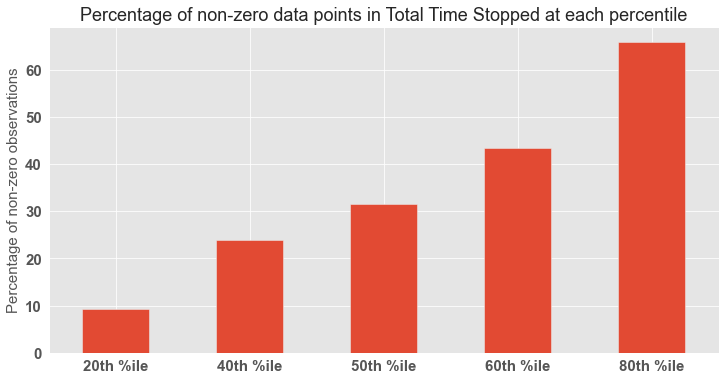

Percentage of observations with non-zero values at 20th percentile: 9.21%
Percentage of observations with non-zero values at 40th percentile: 23.88%
Percentage of observations with non-zero values at 50th percentile: 31.6%
Percentage of observations with non-zero values at 60th percentile: 43.45%
Percentage of observations with non-zero values at 80th percentile: 65.88%


In [10]:
# percentage of non-zero data points at each percentile
pd.DataFrame(zip([round(sum(df['TotalTimeStopped_p20'] != 0) / df.shape[0] * 100, 2),
                  round(sum(df['TotalTimeStopped_p40'] != 0) / df.shape[0] * 100, 2),
                  round(sum(df['TotalTimeStopped_p50'] != 0) / df.shape[0] * 100, 2),
                  round(sum(df['TotalTimeStopped_p60'] != 0) / df.shape[0] * 100, 2),
                  round(sum(df['TotalTimeStopped_p80'] != 0) / df.shape[0] * 100, 2)]))\
.plot(kind='bar', legend=False, figsize=(12,6))
plt.xticks(ticks=[0,1,2,3,4], labels=["20th %ile","40th %ile","50th %ile","60th %ile","80th %ile"], rotation=0,
           fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.ylabel("Percentage of non-zero observations", fontsize=15)
plt.title("Percentage of non-zero data points in Total Time Stopped at each percentile", fontsize=18)
plt.show()

# percentage of non-zero data points at each percentile
print(f"Percentage of observations with non-zero values at 20th percentile: {round(sum(df['TotalTimeStopped_p20'] != 0) / df.shape[0] * 100, 2)}%")
print(f"Percentage of observations with non-zero values at 40th percentile: {round(sum(df['TotalTimeStopped_p40'] != 0) / df.shape[0] * 100, 2)}%")
print(f"Percentage of observations with non-zero values at 50th percentile: {round(sum(df['TotalTimeStopped_p50'] != 0) / df.shape[0] * 100, 2)}%")
print(f"Percentage of observations with non-zero values at 60th percentile: {round(sum(df['TotalTimeStopped_p60'] != 0) / df.shape[0] * 100, 2)}%")
print(f"Percentage of observations with non-zero values at 80th percentile: {round(sum(df['TotalTimeStopped_p80'] != 0) / df.shape[0] * 100, 2)}%")

**Observations:**

For simplicity purpose, let's use 80th percentile values for rest of the calculations and modelling.

## Moving time from first idling

Let's derive `MovingTimeFromFirstIdling`, i.e. time period (sec) for which a vehicle was moving after first idling. Subtracting the idling time at an intersection from total time to pass through an intersection gives us this value.

`MovingTimeFromFirstIdling` = `TimeFromFirstStop_p80` - `TotalTimeStopped_p80`

In [11]:
# deriving MovingTimeFromFirstIdling
df['MovingTimeFromFirstIdling'] = df['TimeFromFirstStop_p80'] - df['TotalTimeStopped_p80']

# replacing the negative values with zero
df['MovingTimeFromFirstIdling'] = df['MovingTimeFromFirstIdling'].apply(lambda x: 0 if x < 0 else x)

## Idling time to moving time ratio

Let's derive `IdlingToMovingRatio`, i.e. ratio of total time vehicle was idling before passing the intersection to total time vehicle was moving after first idling.

`IdlingToMovingRatio` = `TotalTimeStopped_p80` / `MovingTimeFromFirstIdling`

This would also mean, for an unit time a vehicle was moving between the first idling point and crossing an intersection, amount of time vehicle was spending waiting (idling) at the intersection.

A higher ratio value indicates higher chances/levels of congestion at an intersection.

In [12]:
# deriving IdlingToMovingRatio
df['IdlingToMovingRatio'] = (df['TotalTimeStopped_p80'] / df['MovingTimeFromFirstIdling']).round(2)

# in order remove the inf values, capping the values at 10
df['IdlingToMovingRatio'] = df['IdlingToMovingRatio'].apply(lambda x: 10 if x > 10 else x)

# replacing NaN values with 0, since these observations are 0/0
df['IdlingToMovingRatio'].fillna(0, inplace=True)

## Idling time per meter between the intersection and vehicle's first idling point

Let's derive `IdlingTimePerMeterFromFirstStop`, i.e. time vehicle was idling to cover a meter distance between the intersection and point of first idling. It is normalized wait time metric, arrived by dividing it with the distance of first stop from intersection, which is proportionate to the number of vehicles at an intersection.

`IdlingTimePerMeterFromFirstStop` = `TotalTimeStopped_p80` / `DistanceToFirstStop_p80`

A higher value indicates higher/levels chances of congestion.

In [13]:
# deriving IdlingTimePerMeterFromFirstStop
df['IdlingTimePerMeterFromFirstStop'] = (df['TotalTimeStopped_p80'] / df['DistanceToFirstStop_p80']).round(2)

# in order remove the inf values, capping the values at 3
df['IdlingTimePerMeterFromFirstStop'] = df['IdlingTimePerMeterFromFirstStop'].apply(lambda x: 3 if x > 3 else x)

# replacing NaN values with 0, since these observations are 0/0
df['IdlingTimePerMeterFromFirstStop'].fillna(0, inplace=True)

## Total time per each meter between the intersection and vehicle's first idling point

Let's derive `TotalTimePerMeterFromFirstStop`, i.e. time to cover a meter distance between the intersection and point of first idling. It is normalized wait time metric, arrived by dividing it with the distance from intersection, which is proportionate to the number of vehicles at an intersection.

`TotalTimePerMeterFromFirstStop` = `TimeFromFirstStop_p80` / `DistanceToFirstStop_p80`

A higher value indicates higher chances/levels of congestion.

In [14]:
# deriving TotalTimePerMeterFromFirstStop
df['TotalTimePerMeterFromFirstStop'] = (df['TimeFromFirstStop_p80'] / df['DistanceToFirstStop_p80']).round(2)

# in order remove the inf values, capping the values at 3
df['TotalTimePerMeterFromFirstStop'] = df['TotalTimePerMeterFromFirstStop'].apply(lambda x: 3 if x > 3 else x)

# replacing NaN values with 0, since these observations are 0/0
df['TotalTimePerMeterFromFirstStop'].fillna(0, inplace=True)

## Turn angle

Let's calculate the `TurnAngle` from the entry and exit heading values.

In [40]:
# entry heading dict
dict_entry_heading = {'N':0,
                      'NE':45,
                      'E':90,
                      'SE':135,
                      'S':180,
                      'SW':225,
                      'W':270,
                      'NW':315}

# exit heading dict
dict_exit_heading = {'N':360,
                     'NE':45,
                     'E':90,
                     'SE':135,
                     'S':180,
                     'SW':225,
                     'W':270,
                     'NW':315}

# calculating the turn angle
df['TurnAngle'] = df.apply(lambda row: dict_exit_heading[row['ExitHeading']] - dict_entry_heading[row['EntryHeading']],
                           axis=1)

# replacing turn angle 360 with 0, since they both are the same
df['TurnAngle'] = df['TurnAngle'].replace(360, 0)

## Turn type

Let's derive the `TurnType` by analyzing the `EntryHeading` and `TurnAngle`.

In [16]:
# defining a function to derive the turn type
def derive_turn_type(row):
    
    # if the entry heading and exit heading are the same, then it's a straight turn
    if row['EntryHeading'] == row['ExitHeading']:
        return "Straight"
    
    # if turn angle is 180 or -180, then it's a U turn
    elif row['TurnAngle'] in [180,-180]:
        return "U Turn"
    
    # if entry heading angle is in [0,180], then all the right turns take turn angle value in (0,180)
    elif dict_entry_heading[row['EntryHeading']] <= 180:
        if 0 < row['TurnAngle'] < 180:
            return "Right"
        else:
            return "Left"
        
    # if entry heading angle is in [180,360], then all the left turns take turn angle value in (0,-180)
    elif dict_entry_heading[row['EntryHeading']] > 180:
        if -180 < row['TurnAngle'] < 0:
            return "Left"
        else:
            return "Right"
    
    # else return invalid
    else:
        return "Invalid"
    
# deriving the turn type
df['TurnType'] = df.apply(lambda x: derive_turn_type(x), axis=1)

## Street type

Let's define a category for the entry street. `ExitStreetType` will be on of the below:
    - Street
    - Avenue
    - Boulevard
    - Road
    - Drive
    - Highway
    - Other

In [83]:
# defining the exit street type
df['ExitStreetType'] = df['ExitStreetName'].apply(lambda x: 'Other' if type(x) == float else
                                                            'Street' if 'Street' in x.split() else
                                                            'Avenue' if 'Avenue' in x.split() else
                                                            'Boulevard' if 'Boulevard' in x.split() else
                                                            'Road' if 'Road' in x.split() else
                                                            'Drive' if 'Drive' in x.split() else
                                                            'Highway' if 'Highway' in x.split() else 'Other')

## Number of entry headings at an intersection

Let's derive `NoOfEntryHeadings` value by counting the number of unique entry heading values at an intersection.

This will help us understand the type of intersection in a way.
    - If an intersection is having 3 entry headings, then it could possibly be a T or Y intersection type.
    - If an intersection is having 2 or 4 entry headings, then it could possibly be a cross-road intersection type.

In [18]:
# calculating the number of unique entry heading at each intersection
df_intersection_headings = df.groupby(['City','IntersectionId'])['EntryHeading'].nunique()

## Number of streets at an intersection

Let's derive `NoOfStreets` value, by counting the number of unique street names at an intersection.

In [19]:
# identifying unique entry streets
df_intersection_streets = pd.DataFrame(df.groupby(['City','IntersectionId'])['EntryStreetName'].unique())

# identifying unique exit streets
df_intersection_streets['ExitStreetName'] = df.groupby(['City','IntersectionId'])['ExitStreetName'].unique().values

# identifying total unique streets at an intersection
df_intersection_streets['UniqueStreetNames'] = df_intersection_streets.apply(lambda row: list(set(list(row['EntryStreetName']) + list(row['ExitStreetName']))), axis=1)

# counting the no. of unique streets at an intersection
df_intersection_streets['NoOfStreets'] = df_intersection_streets['UniqueStreetNames'].apply(lambda x: len(x))

## Number of turn types at an intersection

Let's count the number of turn types and an intersection and calculate the `NoOfTurnTypes` value.

In [20]:
# calculating the no. of turn types at an intersection
df_intersection_turn_types = pd.DataFrame(df.groupby(['City','IntersectionId'])['TurnType'].nunique())

## Number of turn pairs

Let's count the number of unique turn pairs and calculate `NoOfTurnPairs` at an intersection. This helps us understand the size and dimensions of the intersection.

In [21]:
# counting the number of unique turn pairs at an intersection
df_intersection_turn_pairs = pd.DataFrame(df[['City','IntersectionId','EntryHeading','ExitHeading']]\
                                          .drop_duplicates()\
                                          .groupby(['City','IntersectionId'])\
                                          .size())

## New dataframe with the selected features

In [84]:
# creating a new dataframe with reduced variables
df_new = df[['City','IntersectionId','Latitude','Longitude',
             'EntryStreetName','ExitStreetName','ExitStreetType','EntryHeading','ExitHeading','Path',
             'TurnAngle','TurnType','Month','Hour']]
df_new['Day'] = df['Weekend'].apply(lambda x: "Weekend" if x == 1 else "Weekday")

# for simplicity purpose, we are selecting the 80th percentile values for the three metrics
df_new['TotalTimeStopped'] = df['TotalTimeStopped_p80']
df_new['TimeFromFirstStop'] = df['TimeFromFirstStop_p80']
df_new['DistanceToFirstStop'] = df['DistanceToFirstStop_p80']
df_new['MovingTimeFromFirstIdling'] = df['MovingTimeFromFirstIdling']
df_new['IdlingToMovingRatio'] = df['IdlingToMovingRatio']
df_new['IdlingTimePerMeterFromFirstStop'] = df['IdlingTimePerMeterFromFirstStop']
df_new['TotalTimePerMeterFromFirstStop'] = df['TotalTimePerMeterFromFirstStop']

# checking the rows of new dataframe
df_new.sample(5)

,City,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,ExitStreetType,EntryHeading,ExitHeading,Path,TurnAngle,TurnType,Month,Hour,Day,TotalTimeStopped,TimeFromFirstStop,DistanceToFirstStop,MovingTimeFromFirstIdling,IdlingToMovingRatio,IdlingTimePerMeterToFirstStop,TotalTimePerMeterToFirstStop
253689,Boston,643,42.349859,-71.074808,Clarendon Street,Saint James Avenue,Avenue,SE,SE,Clarendon Street_SE_Saint James Avenue_SE,0,Straight,8,11,Weekday,0.0,0.0,0.0,0.0,0.00,0.00,0.00
611766,Philadelphia,717,40.039014,-75.056259,Tyson Avenue,Tyson Avenue,Avenue,SE,SE,Tyson Avenue_SE_Tyson Avenue_SE,0,Straight,10,16,Weekend,17.0,25.0,71.3,8.0,2.12,0.24,0.35
138742,Atlanta,453,33.791662,-84.374220,Piedmont Avenue Northeast,Piedmont Avenue Northeast,Avenue,SW,SW,Piedmont Avenue Northeast_SW_Piedmont Avenue N...,0,Straight,10,10,Weekday,17.0,26.0,67.2,9.0,1.89,0.25,0.39
282522,Boston,831,42.351427,-71.052863,Dorchester Avenue,Summer Street,Street,SW,SE,Dorchester Avenue_SW_Summer Street_SE,-90,Left,12,15,Weekend,28.0,37.0,63.7,9.0,3.11,0.44,0.58
644327,Philadelphia,889,40.019010,-75.147151,Roosevelt Boulevard,Roosevelt Boulevard,Boulevard,NE,E,Roosevelt Boulevard_NE_Roosevelt Boulevard_E,45,Right,7,12,Weekend,11.0,20.0,65.6,9.0,1.22,0.17,0.30


## Dataframe of intersection summaries

In [23]:
# dataframe of intersection summaries
# no. of entry headings at an intersection
df_intersection_summary = df_new.groupby(['City','IntersectionId','Latitude','Longitude'])\
                                ['EntryHeading'].nunique()\
                                .reset_index()
df_intersection_summary.rename(columns={'EntryHeading':'NoOfEntryHeadings'}, inplace=True)

# no. of streets at an intersection
df_intersection_summary['NoOfStreets'] = df_intersection_streets['NoOfStreets'].values

# no. of turn types at an intersection
df_intersection_summary['NoOfTurnTypes'] = df_intersection_turn_types.values

# no. of turn pairs at an intersection
df_intersection_summary['NoOfTurnPairs'] = df_intersection_turn_pairs.values

# avg. TotalTimeStopped
df_intersection_summary['Avg.TotalTimeStopped'] = df_new.groupby(['City','IntersectionId'])\
                                                        ['TotalTimeStopped'].mean().round(2)\
                                                        .values

# avg. TimeFromFirstStop
df_intersection_summary['Avg.TimeFromFirstStop'] = df_new.groupby(['City','IntersectionId'])\
                                                         ['TimeFromFirstStop'].mean().round(2)\
                                                         .values

# avg. DistanceToFirstStop
df_intersection_summary['Avg.DistanceToFirstStop'] = df_new.groupby(['City','IntersectionId'])\
                                                           ['DistanceToFirstStop'].mean().round(2)\
                                                           .values

# avg. IdlingToMovingRatio
df_intersection_summary['Avg.IdlingToMovingRatio'] = df_new.groupby(['City','IntersectionId'])\
                                                           ['IdlingToMovingRatio'].mean().round(2)\
                                                           .values

# avg. IdlingTimePerMeterFromFirstStop
df_intersection_summary['Avg.IdlingTimePerMeterFromFirstStop'] = df_new.groupby(['City','IntersectionId'])\
                                                                       ['IdlingTimePerMeterFromFirstStop'].mean().round(2)\
                                                                       .values

# avg. TotalTimePerMeterFromFirstStop
df_intersection_summary['Avg.TotalTimePerMeterFromFirstStop'] = df_new.groupby(['City','IntersectionId'])\
                                                                      ['TotalTimePerMeterFromFirstStop'].mean().round(2)\
                                                                      .values

# sample rows
df_intersection_summary.sample(5)

,City,IntersectionId,Latitude,Longitude,NoOfEntryHeadings,NoOfStreets,NoOfTurnTypes,NoOfTurnPairs,Avg.TotalTimeStopped,Avg.TimeFromFirstStop,Avg.DistanceToFirstStop,Avg.IdlingToMovingRatio,Avg.IdlingTimePerMeterToFirstStop,Avg.TotalTimePerMeterToFirstStop
3837,Philadelphia,524,39.975611,-75.262812,3,2,3,3,14.85,22.01,64.51,1.65,0.18,0.26
4290,Philadelphia,1229,39.981504,-75.117382,4,2,3,10,28.98,40.28,113.25,2.58,0.26,0.35
1942,Chicago,786,41.775834,-87.664120,2,1,1,2,0.38,1.00,2.88,0.04,0.01,0.02
1513,Chicago,208,41.768329,-87.683357,2,1,1,2,12.00,17.84,43.95,1.16,0.15,0.23
2696,Chicago,1806,41.968129,-87.739167,2,1,1,2,12.86,20.94,43.91,0.92,0.14,0.22


# Exploratory data analysis

## Number of data points in each city

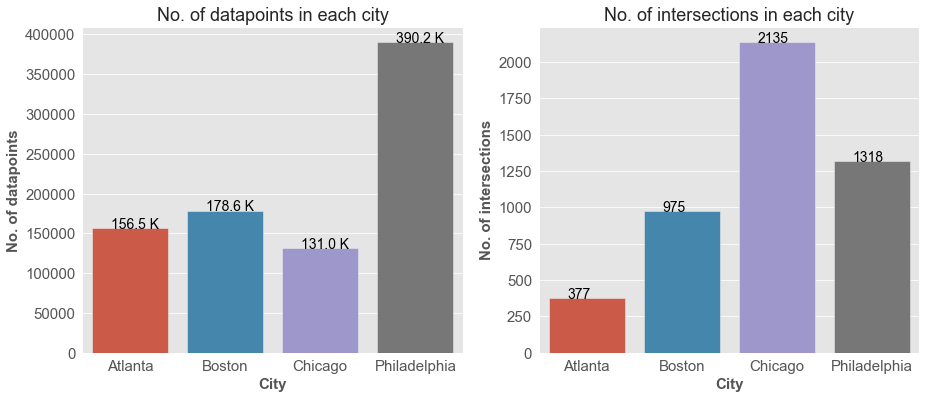

In [222]:
plt.subplots(1,2, figsize=(15,6))

# number of cities and number of observations in each city
plt.subplot(1,2,1)
ax = sns.countplot(df_new['City'])
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.2, i.get_height(), str(round(i.get_height()/1000, 1)) + " K", fontsize=14, color='black')
plt.xlabel("City", fontsize=15, fontweight='bold')
plt.xticks(fontsize=15)
plt.ylabel("No. of datapoints", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15)
plt.title("No. of datapoints in each city", fontsize=18)

# number of intersections in each city
plt.subplot(1,2,2)
ax = sns.countplot(df_new.loc[:, ['City','IntersectionId']].drop_duplicates()['City'])
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.2, i.get_height(), i.get_height(), fontsize=14, color='black')
plt.xlabel("City", fontsize=15, fontweight='bold')
plt.xticks(fontsize=15)
plt.ylabel("No. of intersections", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15)
plt.title("No. of intersections in each city", fontsize=18)

# display the plots
plt.show()

**Observations:**

* Philadelphia has the most number of datapoints.
* Chicago has the highest number of intersections.
* Atlanta has the least number of intersections.

## Avg. waiting time at intersection by time of day

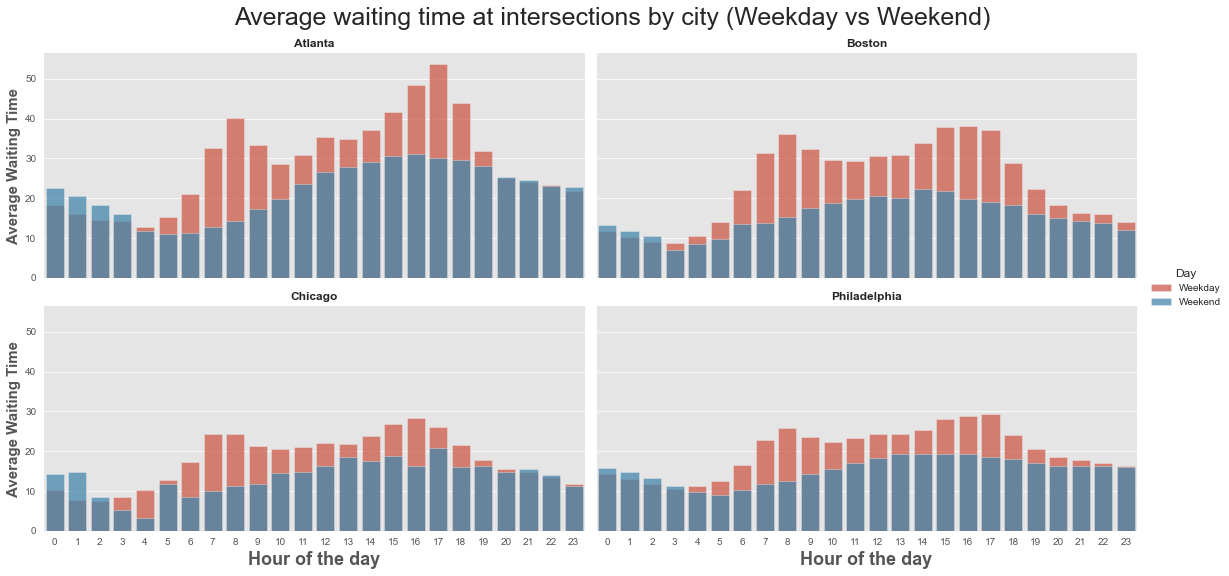

In [223]:
# average waiting time at intersections by city (weekday vs weekend)
grid = sns.FacetGrid(df_new, col='City', hue='Day', col_wrap=2, height=4, aspect=2)
grid.map(sns.barplot, 'Hour', 'TotalTimeStopped', dodge=False, ci=False, alpha=0.75)
grid.add_legend()
grid.set_titles("{col_name}", fontweight='bold')
grid.axes[2].set_xlabel("Hour of the day", fontsize=18, fontweight='bold')
grid.axes[3].set_xlabel("Hour of the day", fontsize=18, fontweight='bold')
grid.axes[0].set_ylabel("Average Waiting Time", fontsize=15, fontweight='bold')
grid.axes[2].set_ylabel("Average Waiting Time", fontsize=15, fontweight='bold')
plt.subplots_adjust(top=0.9)
grid.fig.suptitle("Average waiting time at intersections by city (Weekday vs Weekend)", fontsize=25)

# display plots
plt.show()

**Observations:**

* In general, waiting time at intersection is significantly greater during weekdays than during weekends across all cities.
* Waiting time at intersections is highest during evening time (between 7am-6pm).
* Waiting time at intersections is lowest at the dawn (between 3am-5am).
* During weekdays, waiting time at intersections peaks twice, in the mornings (between 7am-9am) and evenings (between 3pm-6pm).
* During weekends, waiting time at intersections peaks only during evenings, no peak seen during mornings. But, a smaller peak is seen during mid-night.
* In general, waiting time at intersection during evening peak hours is greater than morning peak hours.
* In `Chicago` and `Atlanta`, waiting time at intersection during mid-night (between 12am-1am) is greater during weekends than weekdays. Looks like these cities are having good night life during weekends.
* Average waiting time at intersection at any hour of the day is highest in `Atlanta`, lowest in `Chicago`.

## Avg. time to pass through an intersection by time of day

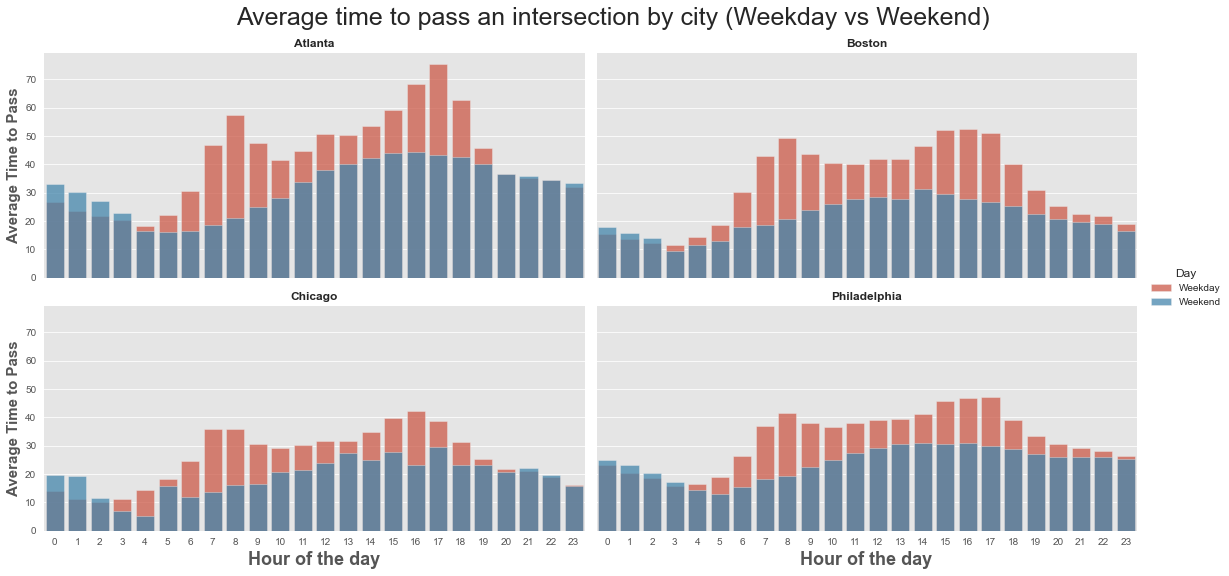

In [224]:
# average time to pass an intersection by city (weekday vs weekend)
grid = sns.FacetGrid(df_new, col='City', hue='Day', col_wrap=2, height=4, aspect=2)
grid.map(sns.barplot, 'Hour', 'TimeFromFirstStop', dodge=False, ci=False, alpha=0.75)
grid.add_legend()
grid.set_titles("{col_name}", fontweight='bold')
grid.axes[2].set_xlabel("Hour of the day", fontsize=18, fontweight='bold')
grid.axes[3].set_xlabel("Hour of the day", fontsize=18, fontweight='bold')
grid.axes[0].set_ylabel("Average Time to Pass", fontsize=15, fontweight='bold')
grid.axes[2].set_ylabel("Average Time to Pass", fontsize=15, fontweight='bold')
plt.subplots_adjust(top=0.9)
grid.fig.suptitle("Average time to pass an intersection by city (Weekday vs Weekend)", fontsize=25)

# display plots
plt.show()

**Observations:**

* In general, patterns of avg. total time to pass through an intersection around the day are similar to avg. waiting times.
* Average total time to pass through an intersection is highest in `Atlanta`, lowest in `Chicago`.

## Exit heading vs time of day

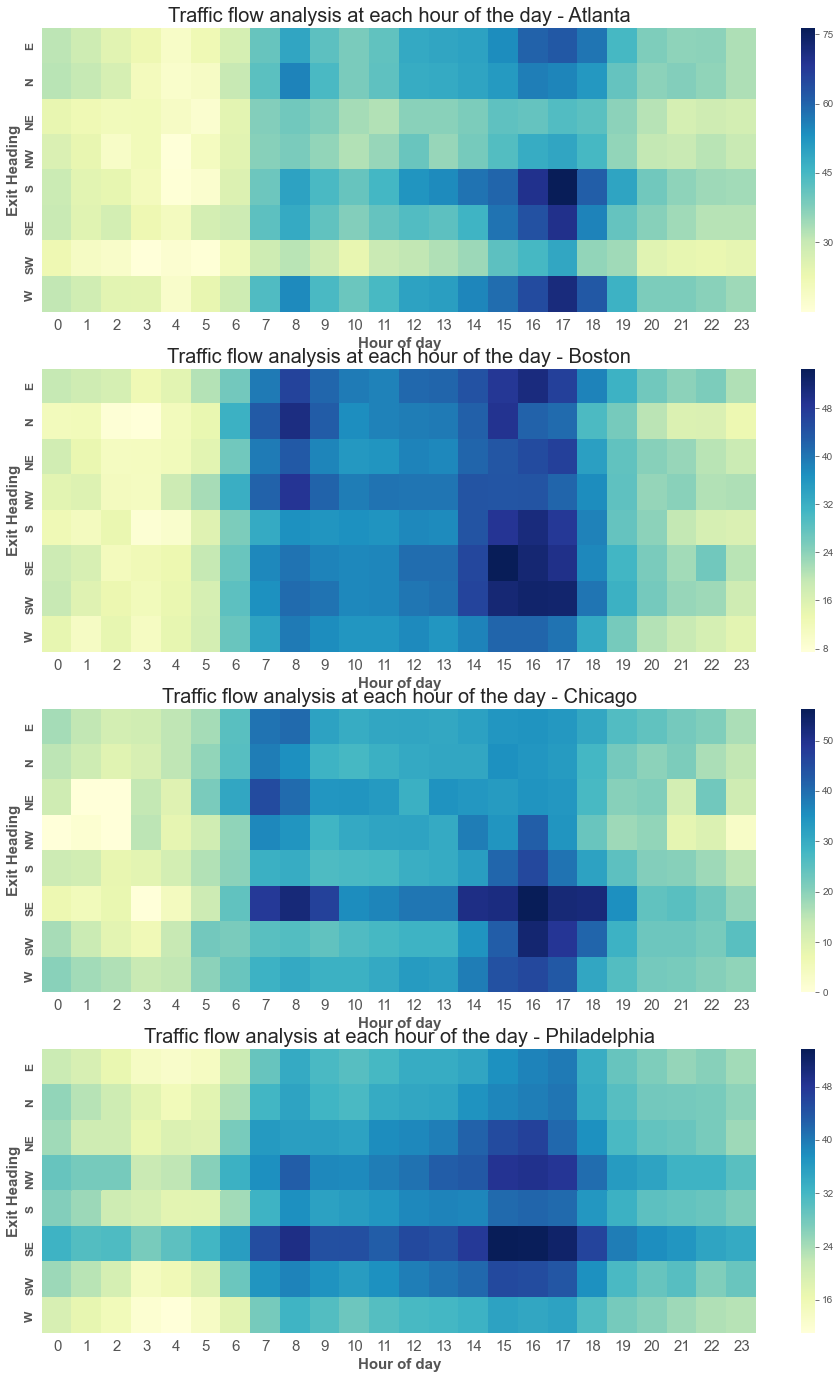

In [112]:
# heatmap of avg. time to pass by exit heading at hour of the day
plt.subplots(4,1, figsize=(16,24))

# city of Atlanta
plt.subplot(4,1,1)
sns.heatmap(df_new[df_new['City'] == "Atlanta"]\
                    .pivot_table(values='TimeFromFirstStop', index='ExitHeading', columns='Hour', fill_value=0),
           cmap='YlGnBu')
plt.xlabel("Hour of day", fontsize=15, fontweight='bold')
plt.xticks(fontsize=15)
plt.ylabel("Exit Heading", fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Traffic flow analysis at each hour of the day - Atlanta", fontsize=20)

# city of Boston
plt.subplot(4,1,2)
sns.heatmap(df_new[df_new['City'] == "Boston"]\
                    .pivot_table(values='TimeFromFirstStop', index='ExitHeading', columns='Hour', fill_value=0),
           cmap='YlGnBu')
plt.xlabel("Hour of day", fontsize=15, fontweight='bold')
plt.xticks(fontsize=15)
plt.ylabel("Exit Heading", fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Traffic flow analysis at each hour of the day - Boston", fontsize=20)

# city of Chicago
plt.subplot(4,1,3)
sns.heatmap(df_new[df_new['City'] == "Chicago"]\
                    .pivot_table(values='TimeFromFirstStop', index='ExitHeading', columns='Hour', fill_value=0),
           cmap='YlGnBu')
plt.xlabel("Hour of day", fontsize=15, fontweight='bold')
plt.xticks(fontsize=15)
plt.ylabel("Exit Heading", fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Traffic flow analysis at each hour of the day - Chicago", fontsize=20)

# city of Philadelphia
plt.subplot(4,1,4)
sns.heatmap(df_new[df_new['City'] == 'Philadelphia']\
                    .pivot_table(values='TimeFromFirstStop', index='ExitHeading', columns='Hour', fill_value=0),
           cmap='YlGnBu')
plt.xlabel("Hour of day", fontsize=15, fontweight='bold')
plt.xticks(fontsize=15)
plt.ylabel("Exit Heading", fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Traffic flow analysis at each hour of the day - Philadelphia", fontsize=20)

# display plot
plt.show()

**Observations:**

* For the city of `Atlanta`,
    - Traffic during morning is flowing towards North, West, South
    - Traffic during evening is flowing towards South, West, Southeast
* For the city of `Boston`,
    - Traffic during morning is flowing towards North, Northwest, East
    - Traffic during evening is flowing towards Southwest, Southeast, East
* For the city of `Chicago`,
    - Traffic during morning is from towards Southeast, Northeast, East
    - Traffic during evening is from towards Southeast, Southwest, South
* For the city of `Philadelphia`,
    - Traffic during morning is from towards Northwest, Southeast
    - Traffic during evening is from towards Northwest, Southeast

## Grid pattern of cities

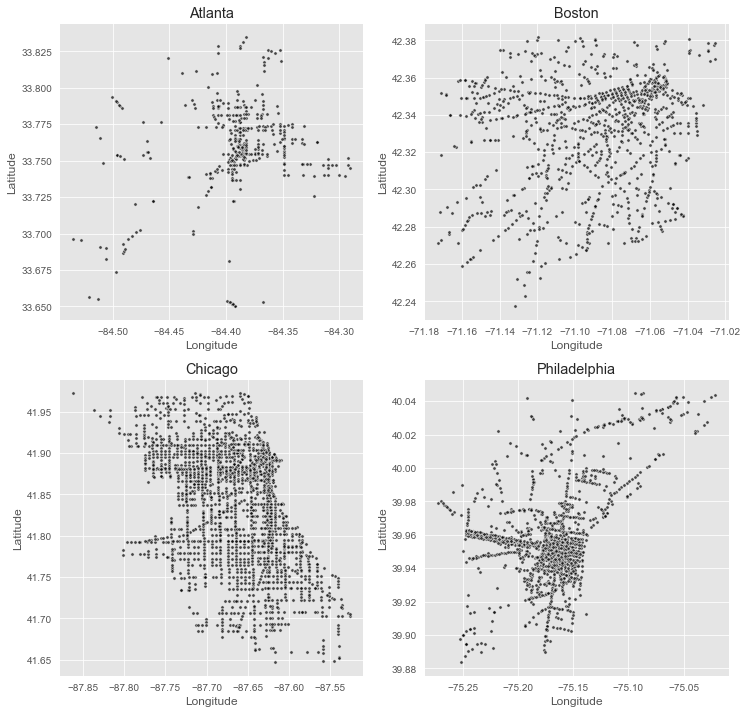

In [256]:
# visualizing the grid patterns in each city
plt.subplots(2,2, figsize=(12,12))

# grid pattern in Atlanta
plt.subplot(2,2,1)
sns.scatterplot(data=df_intersection_summary[df_intersection_summary['City']=="Atlanta"], y='Latitude', x='Longitude',
                color='black', s=12, alpha=0.7)
plt.title("Atlanta")

# grid pattern in Boston
plt.subplot(2,2,2)
sns.scatterplot(data=df_intersection_summary[df_intersection_summary['City']=="Boston"], y='Latitude', x='Longitude',
                color='black', s=12, alpha=0.7)
plt.title("Boston")

# grid pattern in Chicago
plt.subplot(2,2,3)
sns.scatterplot(data=df_intersection_summary[df_intersection_summary['City']=="Chicago"], y='Latitude', x='Longitude',
                color='black', s=12, alpha=0.7)
plt.title("Chicago")

# grid pattern in Philadelphia
plt.subplot(2,2,4)
sns.scatterplot(data=df_intersection_summary[df_intersection_summary['City']=="Philadelphia"], y='Latitude', x='Longitude',
                color='black', s=12, alpha=0.7)
plt.title("Philadelphia")

# display plot
plt.show()

**Observations:**

* We can see that `Chicago` has square grid pattern infrastructure, with most of the intersections being cross-intersections.
* `Boston` city infrastructure is mostly unorganized, with most of the intersections being Y shaped intersections.
* `Philadelphia` city infrastructure is more like a combination of `Boston` and `Chicago`.

## City grid analysis using turn angle

In [49]:
# top 5 turn angle values in each city
pd.DataFrame(zip(df_new[df_new['City'] == "Atlanta"]['TurnAngle'].value_counts().head().index,
                 df_new[df_new['City'] == "Boston"]['TurnAngle'].value_counts().head().index,
                 df_new[df_new['City'] == "Chicago"]['TurnAngle'].value_counts().head().index,
                 df_new[df_new['City'] == "Philadelphia"]['TurnAngle'].value_counts().head().index),
            columns=["Atlanta","Boston","Chicago","Philadelphia"],
            index=["Top 1","Top 2","Top 3","Top 4","Top 5"])

,Atlanta,Boston,Chicago,Philadelphia
Top 1,0,0,0,0
Top 2,90,45,90,90
Top 3,-90,-45,270,-90
Top 4,270,90,-90,270
Top 5,45,-90,45,45


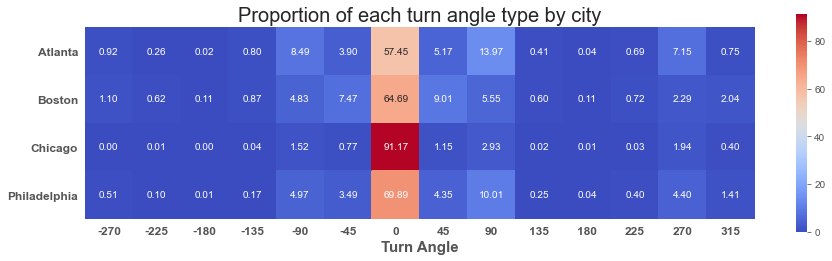

In [57]:
# percentage distribution of type of turn angle in each city
plt.figure(figsize=(15,4))
sns.heatmap((pd.crosstab(df_new['City'], df_new['TurnAngle'], normalize='index') * 100).round(2),
            cmap='coolwarm', annot=True, square=True, fmt='.2f')
plt.xlabel("Turn Angle", fontsize=15, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold', rotation=0)
plt.title("Proportion of each turn angle type by city", fontsize=20)

# display plot
plt.show()

**Observations:**

* In all the cities, `Straight` turns are the significantly majority turn types.
* In `Boston`, we can see that most of the turn angle types are 45 and -45 degrees, which reinstates the fact that most of the intersections in the city are Y-shape intersections.
* In `Chicago`, more than 90% of the times vehicles do not make any turn and head straight at an intersection. Also, majority of the turn types are perpendicular turn types (90, 270, -90 degree turns), which reinstates the fact that most of the intersections in the city are cross-intersections.

## Comparing congestion across cities

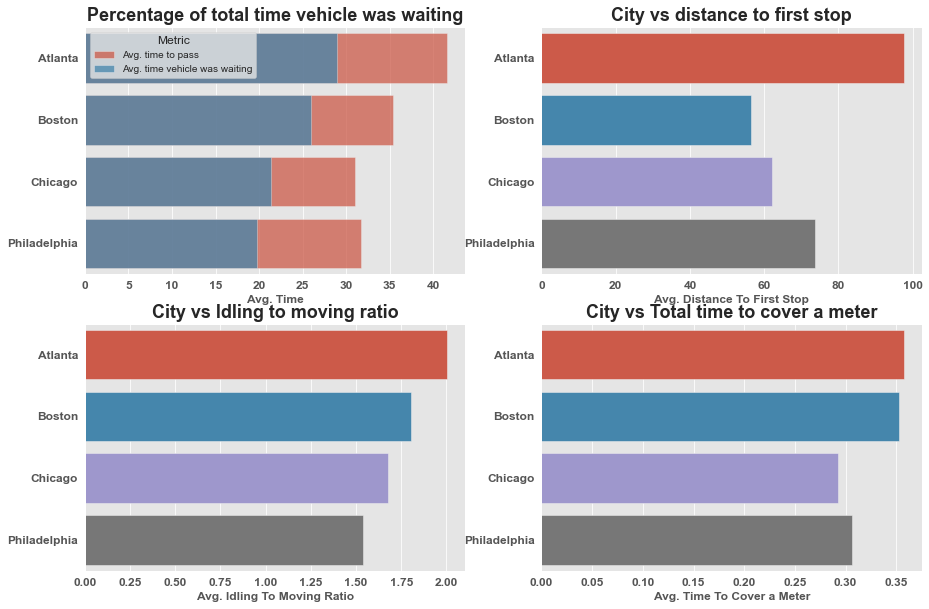

In [109]:
plt.subplots(2,2, figsize=(15,10))

# percentage of total time to pass through an interesection
plt.subplot(2,2,1)
df_temp = pd.melt(df_new[['City','TimeFromFirstStop','TotalTimeStopped']], id_vars='City', var_name='Metric', value_name='Time')
df_temp['Metric'].replace('TimeFromFirstStop', 'Avg. time to pass', inplace=True)
df_temp['Metric'].replace('TotalTimeStopped', 'Avg. time vehicle was waiting', inplace=True)
sns.barplot(data=df_temp, x='Time', y='City', hue='Metric', orient='h', ci=False, dodge=False, alpha=0.75)
plt.xlabel("Avg. Time", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Percentage of total time vehicle was waiting", fontsize=18, fontweight='bold')

# city vs distance from first stop
plt.subplot(2,2,2)
sns.barplot(data=df_intersection_summary, x='Avg.DistanceToFirstStop', y='City', orient='h', ci=False)
plt.xlabel("Avg. Distance To First Stop", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("City vs distance to first stop", fontsize=18, fontweight='bold')

# city vs idling to moving ratio
plt.subplot(2,2,3)
sns.barplot(data=df_intersection_summary, x='Avg.IdlingToMovingRatio', y='City', orient='h', ci=False)
plt.xlabel("Avg. Idling To Moving Ratio", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("City vs Idling to moving ratio", fontsize=18, fontweight='bold')

# city vs total time to cover a meter to first stop
plt.subplot(2,2,4)
sns.barplot(data=df_intersection_summary, x='Avg.TotalTimePerMeterFromFirstStop', y='City', orient='h', ci=False)
plt.xlabel("Avg. Time To Cover a Meter", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("City vs Total time to cover a meter", fontsize=18, fontweight='bold')

# display plot
plt.show()

**Observations:**

* `Boston`, with the least avg. distance of first idling point from an intersection, is having high amount (2nd highest) of avg. wait time and avg. time to pass through an intersection. Also, avg. idling to moving ratio and avg. time to cover a meter at an intersection metrics are high, which are direct measure of congestion. Looks like the intersections in this city are facing high amounts of congestion.

* `Philadelphia` & `Chicago`, despite of having higher values of avg. distance of first idling from an intersection than `Boston`, these cities are having lowest avg. wait time and avg. time to pass through an intersection. This is also reflected in lowest values of avg. idling to moving ratio and avg. time to cover a meter at an intersection metrics, which are direct measure of congestion. In summary, the congestion at intersections in this city is least, and is having free flowing traffic.

## Top 10 intesctions by total time to pass

In [258]:
# top 10 congested intersection (by avg. wait time) and their cities
df_intersection_summary.sort_values('Avg.TotalTimeStopped', ascending=False).head(10)

,City,IntersectionId,Latitude,Longitude,NoOfEntryHeadings,NoOfStreets,NoOfTurnTypes,NoOfTurnPairs,Avg.TotalTimeStopped,Avg.TimeFromFirstStop,Avg.DistanceToFirstStop,Avg.IdlingToMovingRatio,Avg.IdlingTimePerMeterToFirstStop,Avg.TotalTimePerMeterToFirstStop
1279,Boston,1204,42.268857,-71.096035,1,1,1,2,98.67,123.67,184.52,6.20,0.93,1.07
2939,Chicago,2135,41.910443,-87.677528,6,3,2,7,94.40,131.82,209.80,2.97,0.43,0.60
3106,Chicago,2365,41.924003,-87.806251,4,2,3,9,90.27,125.61,268.13,4.01,0.43,0.56
404,Boston,35,42.271528,-71.172645,4,2,4,10,90.26,116.17,219.38,4.90,0.57,0.69
502,Boston,171,42.335471,-71.045514,4,3,3,11,89.50,108.67,128.24,5.42,0.76,0.91
3797,Philadelphia,463,39.977303,-75.226953,5,3,3,13,83.90,145.31,581.83,2.17,0.23,0.34
454,Boston,100,42.290211,-71.071822,5,3,3,13,82.04,109.29,147.93,3.95,0.57,0.75
2557,Chicago,1623,41.891194,-87.647631,6,3,3,12,81.88,107.42,158.03,4.32,0.52,0.68
1126,Boston,997,42.334117,-71.104812,4,4,4,11,80.95,98.62,116.44,3.39,0.51,0.62
2036,Chicago,913,41.721710,-87.624932,3,2,3,4,80.91,103.09,134.03,3.85,0.55,0.71


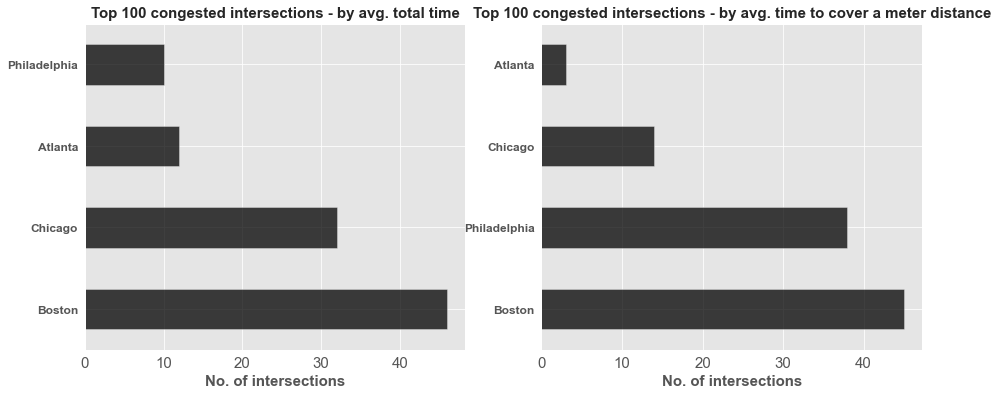

In [265]:
plt.subplots(1,2, figsize=(15,6))

# top 100 congested intersections - by avg. total time to pass through an intersection
plt.subplot(1,2,1)
df_intersection_summary.sort_values('Avg.TotalTimeStopped', ascending=False).head(100)\
      ['City'].value_counts()\
      .plot(kind='barh', color="black", alpha=0.75)
plt.xlabel("No. of intersections", fontsize=15, fontweight='bold')
plt.xticks(fontsize=15)
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Top 100 congested intersections - by avg. wait time", fontsize=15, fontweight='bold')

# top 100 congested intersections - by avg. time to cover a meter distance at an intersection
plt.subplot(1,2,2)
df_intersection_summary.sort_values('Avg.TotalTimePerMeterFromFirstStop', ascending=False).head(100)\
      ['City'].value_counts()\
      .plot(kind='barh', color="black", alpha=0.75)
plt.xlabel("No. of intersections", fontsize=15, fontweight='bold')
plt.xticks(fontsize=15)
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Top 100 congested intersections - by avg. time to cover a meter distance", fontsize=15, fontweight='bold')

# display plot
plt.show()

**Observations:**

* Most of the top congested intersections are in `Boston` and `Chicago`.
* Again, `Boston` is having the most number of intersections among top 100.
* `Chicago` is doing better.

In [123]:
# descriptive statistics of top 100 intersections - by avg. wait time
df_intersection_summary.sort_values('Avg.TotalTimeStopped', ascending=False)\
                       .drop(columns=['City','IntersectionId','Latitude','Longitude'])\
                       .head(100)\
                       .describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
NoOfEntryHeadings,100.0,3.79,1.10,1.00,4.00,4.00,4.00,6.00
NoOfStreets,100.0,2.35,0.72,1.00,2.00,2.00,3.00,4.00
NoOfTurnTypes,100.0,2.73,0.78,1.00,3.00,3.00,3.00,4.00
NoOfTurnPairs,100.0,8.85,3.85,1.00,6.00,10.00,12.00,18.00
Avg.TotalTimeStopped,100.0,64.08,10.12,53.28,56.24,62.26,68.13,98.67
Avg.TimeFromFirstStop,100.0,85.63,16.79,61.00,74.37,81.19,91.54,145.31
Avg.DistanceToFirstStop,100.0,153.45,91.27,45.83,106.56,122.54,161.97,581.83
Avg.IdlingToMovingRatio,100.0,4.05,1.38,1.06,3.10,3.89,4.91,9.83
Avg.IdlingTimePerMeterToFirstStop,100.0,0.52,0.20,0.15,0.39,0.51,0.58,1.69
Avg.TotalTimePerMeterToFirstStop,100.0,0.65,0.19,0.25,0.55,0.64,0.71,1.76


## Average intersection waiting time heatmap - Boston

In [129]:
# heatmap of average waiting at each intersection in Boston
fig = px.scatter_mapbox(df_intersection_summary[df_intersection_summary['City']=="Boston"], 
                        lat='Latitude', lon='Longitude', zoom=11,
                        mapbox_style='stamen-terrain',
                        size='Avg.TotalTimeStopped', size_max=12,
                        color='Avg.TotalTimeStopped', color_continuous_scale = px.colors.sequential.Inferno,
                        hover_data=['IntersectionId'])

# adjusting the margins
fig.update_layout(margin = {"r":0,"t":0,"l":0,"b":0})

# display plot
fig.show()

**Observations:**

* We can observe that avg. wait time is higher at intersections that are converging-diverging (Y-shape) shape intersections.

## Average intersection waiting time heatmap - Chicago

In [132]:
# heatmap of average waiting at each intersection in Chicago
fig = px.scatter_mapbox(df_intersection_summary[df_intersection_summary['City']=="Chicago"], 
                        lat='Latitude', lon='Longitude', zoom=10,
                        mapbox_style='stamen-terrain',
                        size='Avg.TotalTimeStopped', size_max=12,
                        color='Avg.TotalTimeStopped', color_continuous_scale = px.colors.sequential.Inferno,
                        hover_data=['IntersectionId'])

# adjusting the margins
fig.update_layout(margin = {"r":0,"t":0,"l":0,"b":0})

# display plot
fig.show()

**Observations:**

* We can observe that avg. wait time is higher at intersections with 4 and more than 4 entry headings.

## Average intersection waiting time heatmap - Atlanta

In [269]:
# heatmap of average waiting at each intersection in Atlanta
fig = px.scatter_mapbox(df_intersection_summary[df_intersection_summary['City']=="Atlanta"], 
                        lat='Latitude', lon='Longitude', zoom=12,
                        mapbox_style='stamen-terrain',
                        size='Avg.TotalTimeStopped', size_max=12,
                        color='Avg.TotalTimeStopped', color_continuous_scale = px.colors.sequential.Inferno,
                        hover_data=['IntersectionId'])

# adjusting the margins
fig.update_layout(margin = {"r":0,"t":0,"l":0,"b":0})

# display plot
fig.show()

## Average intersection waiting time heatmap - Philadelhia

In [270]:
# heatmap of average waiting at each intersection in Philadelphia
fig = px.scatter_mapbox(df_intersection_summary[df_intersection_summary['City']=="Philadelphia"], 
                        lat='Latitude', lon='Longitude', zoom=11,
                        mapbox_style='stamen-terrain',
                        size='Avg.TotalTimeStopped', size_max=12,
                        color='Avg.TotalTimeStopped', color_continuous_scale = px.colors.sequential.Inferno,
                        hover_data=['IntersectionId'])

# adjusting the margins
fig.update_layout(margin = {"r":0,"t":0,"l":0,"b":0})

# display plot
fig.show()

## Turn angle analysis

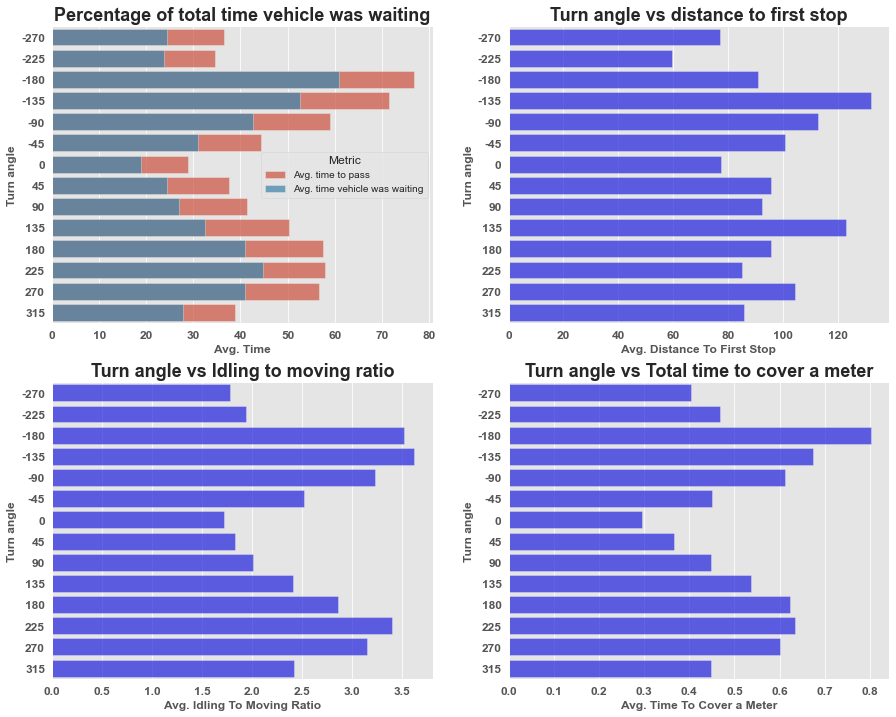

In [68]:
plt.subplots(2,2, figsize=(15,12))

# percentage of total time to pass through an interesection
plt.subplot(2,2,1)
df_temp = pd.melt(df_new[['TurnAngle','TimeFromFirstStop','TotalTimeStopped']], id_vars='TurnAngle', var_name='Metric', value_name='Time')
df_temp['Metric'].replace('TimeFromFirstStop', 'Avg. time to pass', inplace=True)
df_temp['Metric'].replace('TotalTimeStopped', 'Avg. time vehicle was waiting', inplace=True)
sns.barplot(data=df_temp, x='Time', y='TurnAngle', hue='Metric', orient='h', ci=False, dodge=False, alpha=0.75)
plt.xlabel("Avg. Time", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("Turn angle", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Percentage of total time vehicle was waiting", fontsize=18, fontweight='bold')

# turn angle vs distance from first stop
plt.subplot(2,2,2)
sns.barplot(data=df_new, x='DistanceToFirstStop', y='TurnAngle', orient='h', ci=False, color='black', alpha=0.75)
plt.xlabel("Avg. Distance To First Stop", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("Turn angle", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Turn angle vs distance to first stop", fontsize=18, fontweight='bold')

# turn angle vs idling to moving ratio
plt.subplot(2,2,3)
sns.barplot(data=df_new, x='IdlingToMovingRatio', y='TurnAngle', orient='h', ci=False, color='black', alpha=0.75)
plt.xlabel("Avg. Idling To Moving Ratio", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("Turn angle", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Turn angle vs Idling to moving ratio", fontsize=18, fontweight='bold')

# turn angle vs total time to cover a meter to first stop
plt.subplot(2,2,4)
sns.barplot(data=df_new, x='TotalTimePerMeterFromFirstStop', y='TurnAngle', orient='h', ci=False, color='black', alpha=0.75)
plt.xlabel("Avg. Time To Cover a Meter", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("Turn angle", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Turn angle vs Total time to cover a meter", fontsize=18, fontweight='bold')

# display plot
plt.show()

**Observations:**

* As turn angle increases from 0 - 180 degrees, avg. wait time and congestion measures are increasing, with lowest at 0 degrees and highest at 180 degrees.
* Since most of the turn angles in `Chicago` are 0 degrees, we can see that overall congestion levels in that city is low.
* But in `Boston` and `Atlanta`, ~50% of the turns are non-zero turn angles, as a result overall congestion level in the city is high.

## Number of entry headings per intersection analysis

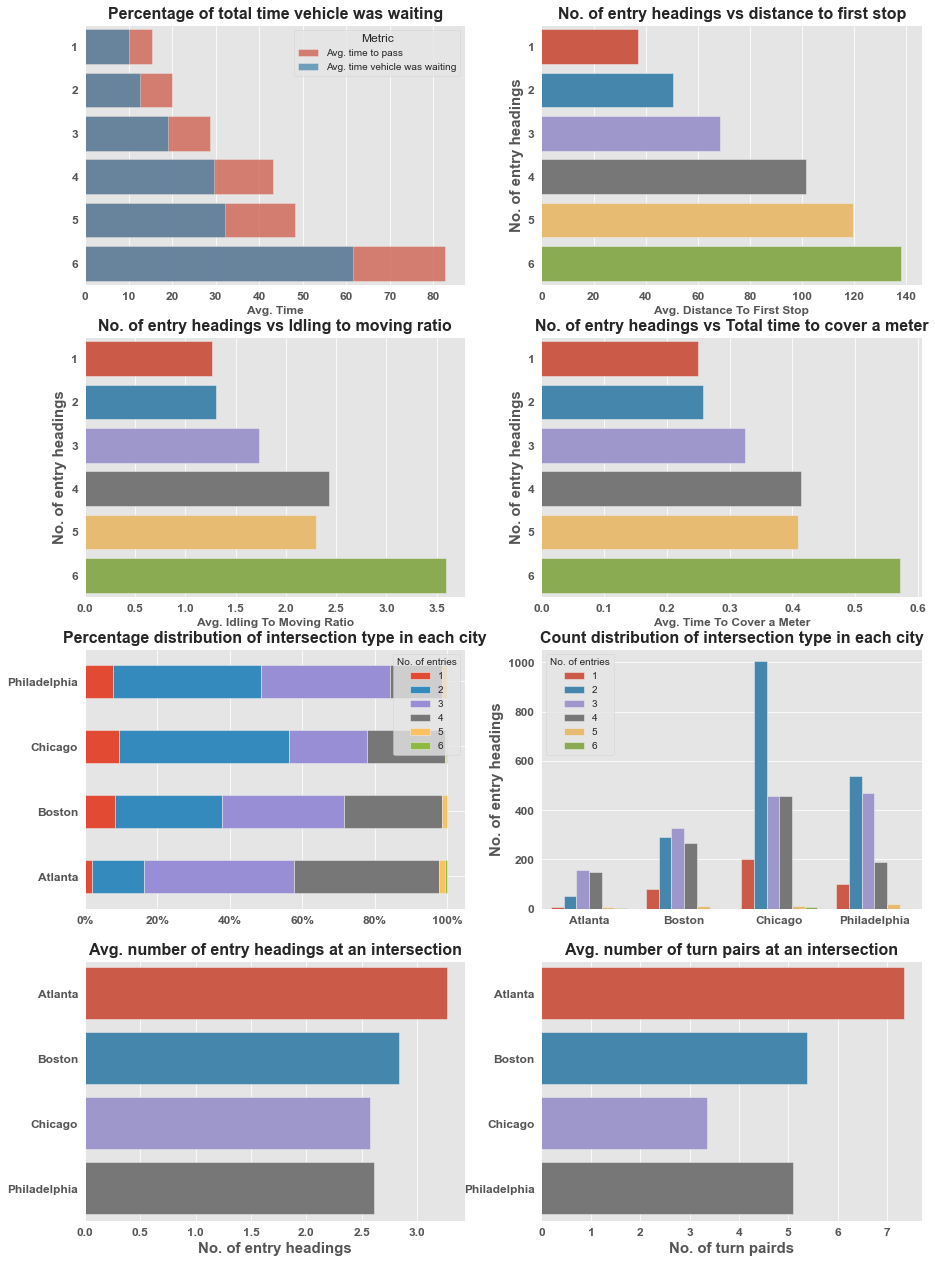

In [79]:
plt.subplots(4,2, figsize=(15,22))

# percentage of total time to pass through an interesection
plt.subplot(4,2,1)
df_temp = pd.melt(df_intersection_summary[['NoOfEntryHeadings','Avg.TimeFromFirstStop','Avg.TotalTimeStopped']],
                  id_vars='NoOfEntryHeadings', var_name='Metric', value_name='Time')
df_temp['Metric'].replace('Avg.TimeFromFirstStop', 'Avg. time to pass', inplace=True)
df_temp['Metric'].replace('Avg.TotalTimeStopped', 'Avg. time vehicle was waiting', inplace=True)
sns.barplot(data=df_temp, x='Time', y='NoOfEntryHeadings', hue='Metric', orient='h', ci=False, dodge=False, alpha=0.75)
plt.xlabel("Avg. Time", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Percentage of total time vehicle was waiting", fontsize=16, fontweight='bold')

# no. of entry headings vs distance from first stop
plt.subplot(4,2,2)
sns.barplot(data=df_intersection_summary, x='Avg.DistanceToFirstStop', y='NoOfEntryHeadings', orient='h', ci=False)
plt.xlabel("Avg. Distance To First Stop", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("No. of entry headings", fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("No. of entry headings vs distance to first stop", fontsize=16, fontweight='bold')

# no. of entry headings vs idling to moving ratio
plt.subplot(4,2,3)
sns.barplot(data=df_intersection_summary, x='Avg.IdlingToMovingRatio', y='NoOfEntryHeadings', orient='h', ci=False)
plt.xlabel("Avg. Idling To Moving Ratio", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("No. of entry headings", fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("No. of entry headings vs Idling to moving ratio", fontsize=16, fontweight='bold')

# no. of entry headings vs total time to cover a meter to first stop
plt.subplot(4,2,4)
sns.barplot(data=df_intersection_summary, x='Avg.TotalTimePerMeterFromFirstStop', y='NoOfEntryHeadings', orient='h', ci=False)
plt.xlabel("Avg. Time To Cover a Meter", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("No. of entry headings", fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("No. of entry headings vs Total time to cover a meter", fontsize=16, fontweight='bold')

# percentage distribution of intersection type (by no. of entry headings) in each city
plt.subplot(4,2,5)
(pd.crosstab(df_intersection_summary['City'], df_intersection_summary['NoOfEntryHeadings'], normalize='index') * 100)\
            .plot(kind='barh', stacked=True, ax=plt.gca())
plt.legend(title="No. of entries", loc='upper right')
plt.xticks(ticks=[0,20,40,60,80,100], labels=["0%","20%","40%","60%","80%","100%"], fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Percentage distribution of intersection type in each city", fontsize=16, fontweight='bold')

# count distribution of intersection type (by no. of entry headings) in each city
plt.subplot(4,2,6)
sns.countplot(data=df_intersection_summary, x='City', hue='NoOfEntryHeadings')
plt.legend(title="No. of entries", loc='upper left')
plt.ylabel("No. of entry headings", fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xlabel("")
plt.xticks(fontsize=12, fontweight='bold')
plt.title("Count distribution of intersection type in each city", fontsize=16, fontweight='bold')

# avg. number of entry headings in each city
plt.subplot(4,2,7)
sns.barplot(data=df_intersection_summary, x='NoOfEntryHeadings', y='City', orient='h', ci=False)
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.xlabel("No. of entry headings", fontsize=15, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.title("Avg. number of entry headings at an intersection", fontsize=16, fontweight='bold')

# avg. number of turn pairs in each city
plt.subplot(4,2,8)
sns.barplot(data=df_intersection_summary, x='NoOfTurnPairs', y='City', orient='h', ci=False)
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.xlabel("No. of turn pairs", fontsize=15, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.title("Avg. number of turn pairs at an intersection", fontsize=16, fontweight='bold')

# display plot
plt.show()

**Observations:**

* Most common intersection types are intersection with 2,3 & 4 entry headings.
* Avg. wait time and congestion increases as no. of entry headings at an intersection increases, being worse for intersections with 4 and 6 entry headings. 
* `Atlanta` is dominated (~80%) by intersections with 3 & 4 entry headings, with highest avg. no of entry headings at an intersection. And this had significantly contributed towards higher intersection wait times and congestion levels in the city.
* `Boston` is also dominated (~60%) by intersections with 3 or more entry headings, with second highest avg. no of entry headings at an intersection. Having intersections with higher number of entry headings had contirbuted to higher intersection wait times and congestion levels in the city.
* `Chicago` is dominated by intersections with 2 or less entry headings, with least avg. no of entry headings at an intersection. Having lesser number of intersections with higher number of entry headings had helped lower the intersection wait times and congestion levels in the city.
* `Philadelphia` is also similar to Boston and so the intersection wait times and congestion levels are also similar to this city.

## Street type at an intersection analysis

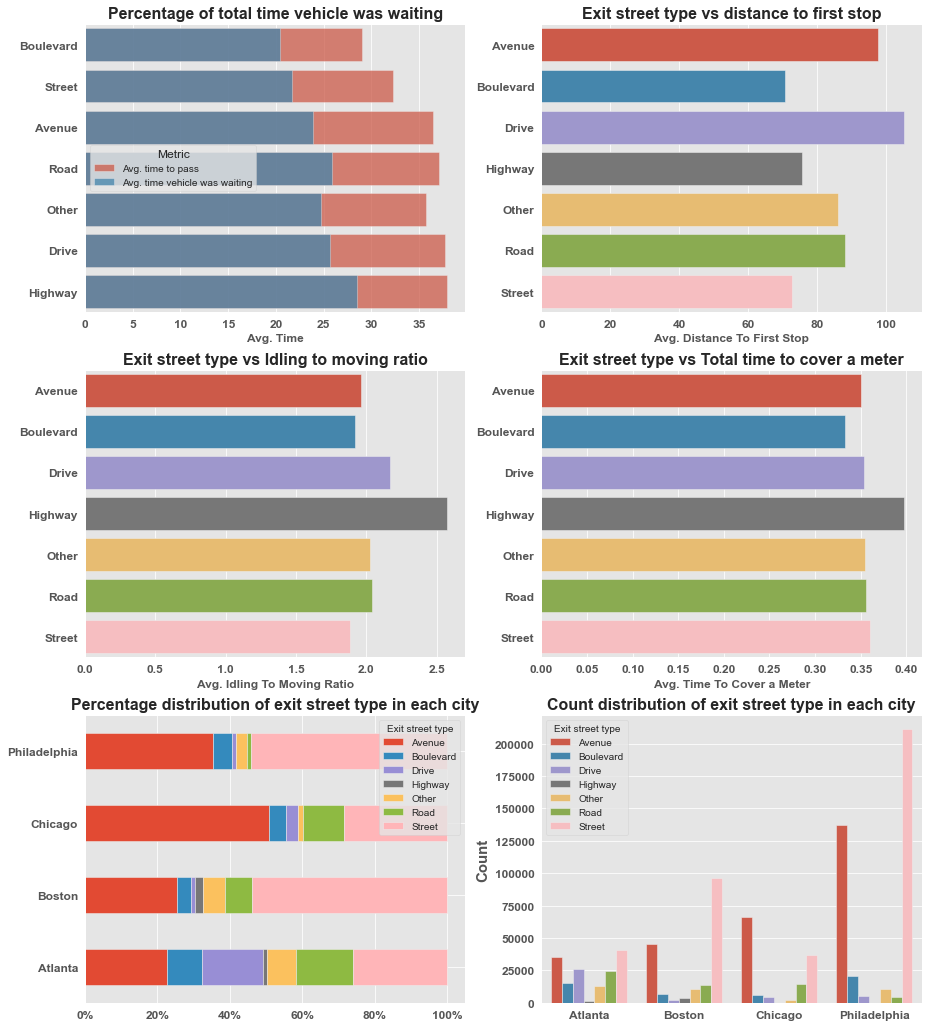

In [102]:
plt.subplots(3,2, figsize=(15,18))

# percentage of total time to pass through an interesection
plt.subplot(3,2,1)
df_temp = pd.melt(df_new[['ExitStreetType','TimeFromFirstStop','TotalTimeStopped']],
                  id_vars='ExitStreetType', var_name='Metric', value_name='Time')
df_temp['Metric'].replace('TimeFromFirstStop', 'Avg. time to pass', inplace=True)
df_temp['Metric'].replace('TotalTimeStopped', 'Avg. time vehicle was waiting', inplace=True)
sns.barplot(data=df_temp, x='Time', y='ExitStreetType', hue='Metric', orient='h', ci=False, dodge=False, alpha=0.75)
plt.xlabel("Avg. Time", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Percentage of total time vehicle was waiting", fontsize=16, fontweight='bold')

# exit street type vs distance from first stop
plt.subplot(3,2,2)
sns.barplot(data=df_new.groupby('ExitStreetType')['DistanceToFirstStop'].mean().reset_index(),
            x='DistanceToFirstStop', y='ExitStreetType', orient='h', ci=False)
plt.xlabel("Avg. Distance To First Stop", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Exit street type vs distance to first stop", fontsize=16, fontweight='bold')

# exit street type vs idling to moving ratio
plt.subplot(3,2,3)
sns.barplot(data=df_new.groupby('ExitStreetType')['IdlingToMovingRatio'].mean().reset_index(),
            x='IdlingToMovingRatio', y='ExitStreetType', orient='h', ci=False)
plt.xlabel("Avg. Idling To Moving Ratio", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Exit street type vs Idling to moving ratio", fontsize=16, fontweight='bold')

# exit street type vs total time to cover a meter to first stop
plt.subplot(3,2,4)
sns.barplot(data=df_new.groupby('ExitStreetType')['TotalTimePerMeterFromFirstStop'].mean().reset_index(),
            x='TotalTimePerMeterFromFirstStop', y='ExitStreetType', orient='h', ci=False)
plt.xlabel("Avg. Time To Cover a Meter", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Exit street type vs Total time to cover a meter", fontsize=16, fontweight='bold')

# percentage distribution of exit street type in each city
plt.subplot(3,2,5)
(pd.crosstab(df_new['City'], df_new['ExitStreetType'], normalize='index') * 100)\
            .plot(kind='barh', stacked=True, ax=plt.gca())
plt.legend(title="Exit street type", loc='upper right')
plt.xticks(ticks=[0,20,40,60,80,100], labels=["0%","20%","40%","60%","80%","100%"], fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Percentage distribution of exit street type in each city", fontsize=16, fontweight='bold')

# count distribution of exit street type in each city
plt.subplot(3,2,6)
sns.barplot(data=df_new.groupby(['City','ExitStreetType']).size().reset_index(), x='City', y=0, hue='ExitStreetType')
plt.legend(title="Exit street type", loc='upper left')
plt.ylabel("Count", fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xlabel("")
plt.xticks(fontsize=12, fontweight='bold')
plt.title("Count distribution of exit street type in each city", fontsize=16, fontweight='bold')

# display plot
plt.show()

**Observations:**

* Congestion levels or wait time is higher when you are trying to enter `Highway` after exiting an intersection. There is no significant difference in wait time or congestion levels for rest of the exit street types.

## Turn type analysis

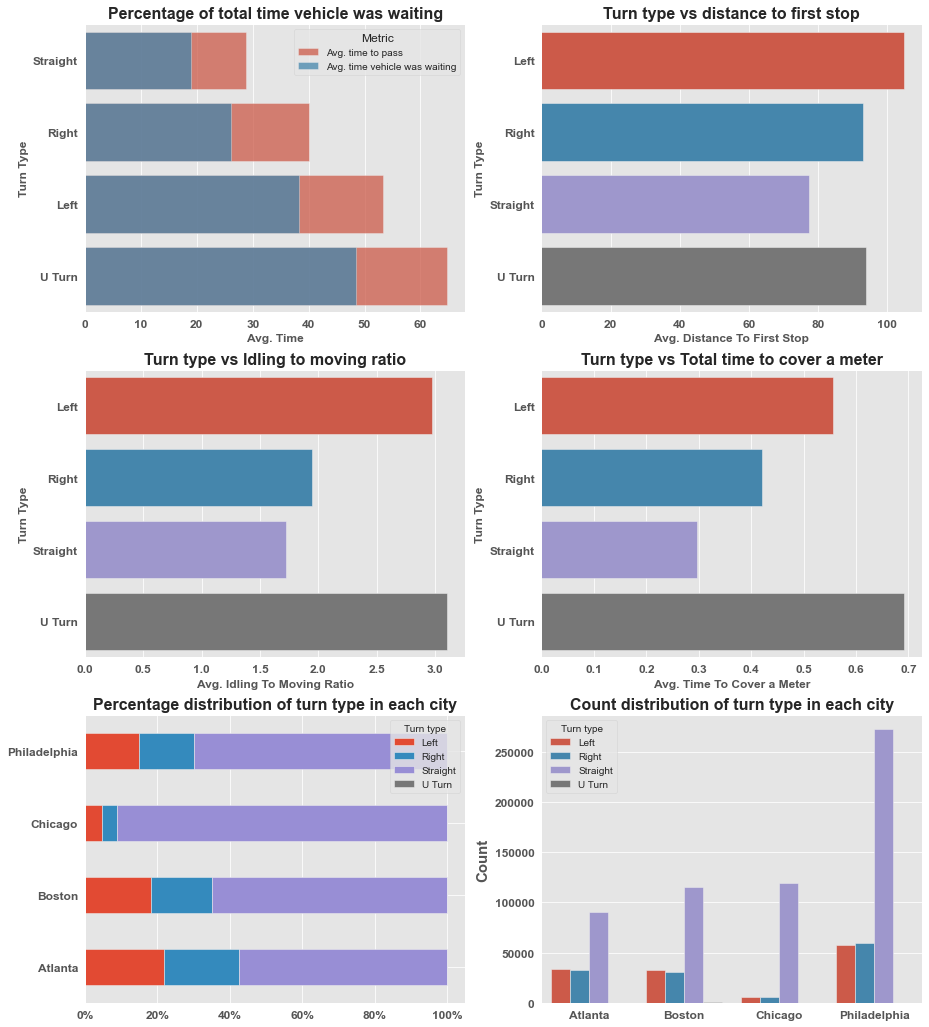

In [106]:
plt.subplots(3,2, figsize=(15,18))

# percentage of total time to pass through an interesection
plt.subplot(3,2,1)
df_temp = pd.melt(df_new[['TurnType','TimeFromFirstStop','TotalTimeStopped']],
                  id_vars='TurnType', var_name='Metric', value_name='Time')
df_temp['Metric'].replace('TimeFromFirstStop', 'Avg. time to pass', inplace=True)
df_temp['Metric'].replace('TotalTimeStopped', 'Avg. time vehicle was waiting', inplace=True)
sns.barplot(data=df_temp, x='Time', y='TurnType', hue='Metric', orient='h', ci=False, dodge=False, alpha=0.75)
plt.xlabel("Avg. Time", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("Turn Type", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Percentage of total time vehicle was waiting", fontsize=16, fontweight='bold')

# turn type vs distance from first stop
plt.subplot(3,2,2)
sns.barplot(data=df_new.groupby('TurnType')['DistanceToFirstStop'].mean().reset_index(),
            x='DistanceToFirstStop', y='TurnType', orient='h', ci=False)
plt.xlabel("Avg. Distance To First Stop", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("Turn Type", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Turn type vs distance to first stop", fontsize=16, fontweight='bold')

# turn type vs idling to moving ratio
plt.subplot(3,2,3)
sns.barplot(data=df_new.groupby('TurnType')['IdlingToMovingRatio'].mean().reset_index(),
            x='IdlingToMovingRatio', y='TurnType', orient='h', ci=False)
plt.xlabel("Avg. Idling To Moving Ratio", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("Turn Type", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Turn type vs Idling to moving ratio", fontsize=16, fontweight='bold')

# turn type vs total time to cover a meter to first stop
plt.subplot(3,2,4)
sns.barplot(data=df_new.groupby('TurnType')['TotalTimePerMeterFromFirstStop'].mean().reset_index(),
            x='TotalTimePerMeterFromFirstStop', y='TurnType', orient='h', ci=False)
plt.xlabel("Avg. Time To Cover a Meter", fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel("Turn Type", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Turn type vs Total time to cover a meter", fontsize=16, fontweight='bold')

# percentage distribution of turn type in each city
plt.subplot(3,2,5)
(pd.crosstab(df_new['City'], df_new['TurnType'], normalize='index') * 100)\
            .plot(kind='barh', stacked=True, ax=plt.gca())
plt.legend(title="Turn type", loc='upper right')
plt.xticks(ticks=[0,20,40,60,80,100], labels=["0%","20%","40%","60%","80%","100%"], fontsize=12, fontweight='bold')
plt.ylabel("")
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Percentage distribution of turn type in each city", fontsize=16, fontweight='bold')

# count distribution of turn type in each city
plt.subplot(3,2,6)
sns.barplot(data=df_new.groupby(['City','TurnType']).size().reset_index(), x='City', y=0, hue='TurnType')
plt.legend(title="Turn type", loc='upper left')
plt.ylabel("Count", fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xlabel("")
plt.xticks(fontsize=12, fontweight='bold')
plt.title("Count distribution of turn type in each city", fontsize=16, fontweight='bold')

# display plot
plt.show()

**Observations:**

* We can see that the avg. wait time and avg. distance to first stop from an intersection are lowest for straight turns and highest for U turns.

![Left turn vs Right turn](https://raw.githubusercontent.com/xalemsharan/intersection_congestion/master/LeftvsRight_Turn.JPG)

* Also, the avg. wait time to make a left turn is 50% higher than avg. wait time to make a right turn. That's because, in order to make a left turn you might have to wait for a green light and traffic in the opposite direction as well as perpendicular direction to stop in order to make the turn. But, in order to make a right turn, you can make even if traffic in the opposite direction is flowing and if there's relatively fewer amount of traffic flowing in the perpendicular direction.
* Also, we can see that majority (~90%) of the turn types in `Chicago` are straight turns. This city has the highest proportion of straight turn types, making it lowest in avg. waiting time and an intersection among the 4 cities.
* `Atlanta` has the least proprotion of straight turn types, making it highest in avg. waiting time at an intersection among the 4 cities.

# A tale of two cities - Boston vs Chicago

**City of Chicago:**

The construction of the city was organized, with most of the city blocks and roads being perpendicular to each other. As a result of this construction, most of the intersections in the city are cross-road intersections. These types of intersections have several advantages:

1. Straight turns take the least amount of time to cross an intersection and does not cause any significant levels of congestion in the city. Such cross-road intersections facilitate an advantage of entering and exiting an intersection without making a turn or zero turn angle, i.e. straight turns.
2. This helps in strategically idenifying intersections where left/right/U turns can be banned and only allow traffic in one/straight direction can help reduce congestion levels while not impairing the mobility around the city.
3. Also, with such network of roads, one can reach from point A to point B in the city with minimal number of turns and keeping most of the journey turnless and with straight turns at the intersections.

![Chicago - A to B](https://raw.githubusercontent.com/xalemsharan/intersection_congestion/master/Chicago_AtoB.JPG)

All these factors together have significantly contributed towards keeping the average waiting times and congestion levels around the city at much lower values.

**City of Boston:**

The constuction of the city is unorganized. As a result of this construction, most of the city blocks and roads are non-perpendicular and more like Y shaped intersections, reducing the possibility for cross-road intersections. As a result of such a network of roads:

1. Such type of intersections inhibit the possibility of entering and exiting an intersection without making a turn or zero turn angle, i.e. straight turns, forcing drivers to make some non-zero turn angle turns at every intersection. This significantly reduces the overall number of straight turns in the city, increasing the congestion and wait times.
2. Also, such a network of roads would increase the average number of turns one must take in order to travel from point A to point B in the city, making the journey haphazard.

![Boston - A to B](https://raw.githubusercontent.com/xalemsharan/intersection_congestion/master/Boston_AtoB.JPG)

All these factors together have significantly contributed towards increasing the average number of turns in the city and hence average wait times and congestion levels around the city.